In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from ultralytics import YOLO
import numpy as np
import cv2
from pathlib import Path
import yaml
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Ti


# Multi-Task Pothole Detection with Severity Classification

This notebook implements a multi-task learning model that:
1. **Detects potholes** using YOLO11n
2. **Classifies severity** (Minor/Moderate/Severe) for each detected pothole

## Project Structure
```
runs/detect/
├── 01_baseline_yolo11n/      # YOLO11n baseline model
├── 02_baseline_yolov8n/       # YOLOv8n baseline model  
├── 03_multitask_severity/     # Multi-task model (Detection + Severity)
│   ├── weights/
│   │   ├── best.pt           # Best detection weights
│   │   └── last.pt           # Last checkpoint
│   ├── severity_head_best.pt # Best severity classification head
│   ├── severity_training_history.png
│   └── inference_examples.png
├── custom_hybrid/             # Experimental hybrid models
└── archive_old_runs/          # Old training/validation runs
```

## 1. Load Dataset with Severity Labels

In [2]:
class PotholeDatasetWithSeverity(Dataset):
    """Dataset loader for pothole detection with severity labels.
    
    Label format: class_id x_center y_center width height severity
    """
    
    def __init__(self, images_dir, labels_dir, img_size=640, augment=False):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.img_size = img_size
        self.augment = augment
        
        # Get all image files
        self.image_files = sorted(list(self.images_dir.glob('*.jpg')))
        print(f"Found {len(self.image_files)} images in {images_dir}")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Load labels
        label_path = self.labels_dir / f"{img_path.stem}.txt"
        
        boxes = []
        severities = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 6:  # class x y w h severity
                        cls, x, y, bw, bh, sev = map(float, parts)
                        boxes.append([x, y, bw, bh])
                        severities.append(int(sev))
        
        # Resize image
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC -> CHW
        
        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            severities = torch.tensor(severities, dtype=torch.long)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            severities = torch.zeros((0,), dtype=torch.long)
        
        return {
            'image': image,
            'boxes': boxes,
            'severities': severities,
            'img_path': str(img_path)
        }

# Test dataset loading
train_dataset = PotholeDatasetWithSeverity(
    images_dir='train/images',
    labels_dir='severity_labels/train/labels',
    img_size=640
)

# Show sample
sample = train_dataset[0]
print(f"\nSample data:")
print(f"Image shape: {sample['image'].shape}")
print(f"Number of boxes: {len(sample['boxes'])}")
print(f"Severities: {sample['severities'].tolist()}")

Found 1502 images in train/images

Sample data:
Image shape: torch.Size([3, 640, 640])
Number of boxes: 5
Severities: [0, 2, 0, 0, 0]


## 2. Multi-Task Model Architecture

Architecture:
```
Input Image (640x640)
    |
    v
YOLO11n Backbone (shared features)
    |
    +---> YOLO Detection Head (bounding boxes)
    |
    +---> Severity Classification Head (minor/moderate/severe per box)
```

In [3]:
class SeverityClassificationHead(nn.Module):
    """Severity classification head that processes RoI features.
    
    Takes features from detected boxes and classifies severity.
    """
    
    def __init__(self, in_channels=128, num_classes=3, roi_size=7):
        super().__init__()
        self.roi_size = roi_size
        self.num_classes = num_classes
        
        # Feature extraction for RoI
        self.conv1 = nn.Conv2d(in_channels, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Global average pooling + classification
        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, num_classes)
        
    def forward(self, features, boxes):
        """Forward pass.
        
        Args:
            features: Feature map from backbone [B, C, H, W]
            boxes: Normalized bounding boxes [N, 4] (x, y, w, h)
            
        Returns:
            severity_logits: Classification logits [N, num_classes]
        """
        if len(boxes) == 0:
            return torch.zeros((0, self.num_classes), device=features.device)
        
        # Extract RoI features using RoI pooling approximation
        roi_features = self.extract_roi_features(features, boxes)
        
        # Process RoI features
        x = F.relu(self.bn1(self.conv1(roi_features)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.flatten(1)
        
        # Classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def extract_roi_features(self, features, boxes):
        """Extract RoI features from feature map.
        
        Args:
            features: Feature map [1, C, H, W] for a single image
            boxes: Boxes for this image [N, 4]
        """
        _, channels, feat_h, feat_w = features.shape
        roi_features_list = []
        
        for box in boxes:
            # Convert normalized box to feature map coordinates
            # Extract scalar values from tensor - handle both 1D and 0D tensors
            if isinstance(box, torch.Tensor):
                box_vals = box.flatten().tolist()
                x_center, y_center, w, h = box_vals[0], box_vals[1], box_vals[2], box_vals[3]
            else:
                x_center, y_center, w, h = box
            
            x1 = int((x_center - w/2) * feat_w)
            y1 = int((y_center - h/2) * feat_h)
            x2 = int((x_center + w/2) * feat_w)
            y2 = int((y_center + h/2) * feat_h)
            
            # Clamp to feature map bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(feat_w, x2), min(feat_h, y2)
            
            # Extract and resize RoI
            if x2 > x1 and y2 > y1:
                roi = features[:, :, y1:y2, x1:x2]
                roi = F.interpolate(roi, size=(self.roi_size, self.roi_size), 
                                   mode='bilinear', align_corners=False)
            else:
                roi = torch.zeros((1, channels, self.roi_size, self.roi_size),
                                device=features.device)
            
            roi_features_list.append(roi)
        
        # Stack all RoIs
        roi_features = torch.cat(roi_features_list, dim=0)
        return roi_features

print("Severity classification head defined")

Severity classification head defined


In [4]:
class MultiTaskPotholeDetector(nn.Module):
    """Multi-task model combining YOLO11n detection with severity classification."""
    
    def __init__(self, yolo_model_path='yolo11n.pt', num_severity_classes=3):
        super().__init__()
        
        # Load YOLO11n for detection
        self.yolo = YOLO(yolo_model_path)
        
        # Add severity classification head
        # YOLO11n backbone outputs features at different scales
        # We'll use layer 6 features (40x40 @ 128 channels)
        self.severity_head = SeverityClassificationHead(
            in_channels=128,
            num_classes=num_severity_classes
        )
        
    def forward(self, images, boxes=None, mode='train'):
        """
        Args:
            images: Input images [B, 3, H, W]
            boxes: List of boxes per image, each [N_i, 4]
            mode: 'train' or 'eval'
            
        Returns:
            detection_results: YOLO detection outputs
            severity_logits: Severity classification logits
        """
        # Get YOLO detection results
        if mode == 'train':
            # During training, we use ground truth boxes for severity classification
            # (teacher forcing to stabilize training)
            detection_results = None  # YOLO handles its own loss internally
            
            # Get backbone features for severity classification
            # Process each image separately since boxes are per-image
            all_severity_logits = []
            
            for i in range(len(images)):
                img_features = self.extract_features(images[i:i+1])
                img_boxes = boxes[i] if boxes is not None and i < len(boxes) else []
                
                if len(img_boxes) > 0:
                    img_severity_logits = self.severity_head(img_features, img_boxes)
                    all_severity_logits.append(img_severity_logits)
            
            if len(all_severity_logits) > 0:
                severity_logits = torch.cat(all_severity_logits, dim=0)
            else:
                severity_logits = torch.zeros((0, 3), device=images.device)
                
        else:
            # During inference, use detected boxes
            detection_results = self.yolo(images, verbose=False)
            features = self.extract_features(images)
            
            # Extract boxes from detection results
            detected_boxes = self.get_boxes_from_results(detection_results)
            
            if len(detected_boxes) > 0:
                severity_logits = self.severity_head(features, detected_boxes)
            else:
                severity_logits = torch.zeros((0, 3), device=images.device)
        
        return detection_results, severity_logits
    
    def extract_features(self, images):
        """Extract feature map from YOLO backbone."""
        # This is a simplified version - we'll access YOLO's backbone
        model = self.yolo.model
        
        # Forward through backbone to get features
        # YOLO11n has multiple feature levels, we use P4 (80x80 resolution)
        x = images
        
        # Get features from backbone (before detection head)
        features = []
        for i, m in enumerate(model.model[:10]):  # First 10 layers are backbone
            x = m(x)
            if i == 6:  # P4 features at layer 6
                features.append(x)
        
        return features[0] if features else x
    
    def get_boxes_from_results(self, results):
        """Extract normalized boxes from YOLO results."""
        boxes = []
        for result in results:
            if result.boxes is not None and len(result.boxes) > 0:
                # Get boxes in xywh normalized format
                xywhn = result.boxes.xywhn.cpu()  # [N, 4] tensor
                for i in range(len(xywhn)):
                    boxes.append(xywhn[i])
        
        if len(boxes) > 0:
            boxes_tensor = torch.stack(boxes)
            if results[0].boxes is not None:
                boxes_tensor = boxes_tensor.to(results[0].boxes.data.device)
            return boxes_tensor
        return torch.zeros((0, 4), dtype=torch.float32)

print("Multi-task model architecture defined")

Multi-task model architecture defined


## 3. Training Strategy

**Two-Stage Training Approach**:

### Stage 1: Train YOLO11n for Detection (Standard Fine-tuning)
- Use ultralytics YOLO training
- Fine-tune on pothole dataset
- Target: High detection mAP (>0.75)

### Stage 2: Freeze Detection, Train Severity Head
- Freeze YOLO backbone and detection head
- Train only severity classification head
- Use detected boxes for RoI extraction

This approach is more practical and stable than joint training.

## Stage 1: Train YOLO11n Detection

In [5]:
# Train YOLO11n for detection (auto-versioned approach)
print("Stage 1: Training YOLO11n for pothole detection...")
print("="*60)

from pathlib import Path
import re

def get_next_run_version(base_name='multitask_severity'):
    """Find next version number for complete experiment runs."""
    runs_dir = Path('runs/detect')
    if not runs_dir.exists():
        return 1
    
    # Find all matching directories
    pattern = re.compile(rf'(\d+)_{re.escape(base_name)}')
    versions = []
    
    for d in runs_dir.iterdir():
        if d.is_dir():
            match = pattern.match(d.name)
            if match:
                versions.append(int(match.group(1)))
    
    # Return next version number
    return max(versions) + 1 if versions else 1

# Get next version for this run
run_version = get_next_run_version('multitask_severity')
detection_model_name = f'{run_version:02d}_multitask_severity'
detection_model_path = Path(f'runs/detect/{detection_model_name}')

print(f"🆕 Creating new run: {detection_model_name}")
print("="*60)

# Load pretrained YOLO11n
model = YOLO('yolo11n.pt')

# Training configuration
train_args = {
    'data': 'data.yaml',
    'epochs': 100,
    'batch': 16,
    'imgsz': 640,
    'device': 0,
    'patience': 50,
    'save': True,
    'project': 'runs/detect',
    'name': detection_model_name,
    'exist_ok': False,
    'pretrained': True,
    'optimizer': 'Adam',
    'lr0': 0.001,
    'weight_decay': 0.0005,
    'verbose': True
}

# Start training
print(f"\nTraining configuration:")
for key, value in train_args.items():
    print(f"  {key}: {value}")

results = model.train(**train_args)

print("\n" + "="*60)
print("Stage 1 Training Complete!")
print("="*60)

Stage 1: Training YOLO11n for pothole detection...
🆕 Creating new run: 02_multitask_severity

Training configuration:
  data: data.yaml
  epochs: 100
  batch: 16
  imgsz: 640
  device: 0
  patience: 50
  save: True
  project: runs/detect
  name: 02_multitask_severity
  exist_ok: False
  pretrained: True
  optimizer: Adam
  lr0: 0.001
  weight_decay: 0.0005
  verbose: True
New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, cop

In [6]:
# Show current run information
from pathlib import Path

print("Current Run Information")
print("="*60)

model_path = Path(f'runs/detect/{detection_model_name}')

if model_path.exists():
    print(f"\n📦 Run: {detection_model_name}")
    print(f"  📁 Directory: {model_path}")
    
    # Check detection weights
    if (model_path / 'weights' / 'best.pt').exists():
        print(f"  ✓ Detection training completed")
        
        # Validate to show metrics (save results in run directory)
        print(f"\n  Validating on test set...")
        try:
            model = YOLO(str(model_path / 'weights' / 'best.pt'))
            # Save validation results in the run directory
            val_save_dir = model_path / 'validation'
            val_save_dir.mkdir(exist_ok=True)
            metrics = model.val(data='data.yaml', split='test', project=str(val_save_dir), name='test_results', exist_ok=True)
            print(f"    mAP@0.5: {metrics.box.map50:.4f}")
            print(f"    Validation results saved: {val_save_dir / 'test_results'}")
        except Exception as e:
            print(f"    Validation error: {e}")
    else:
        print(f"  ✗ Detection weights not found")
    
    print(f"\n  Next: Training severity classification head...")
else:
    print(f"\n✗ Model directory not found: {detection_model_name}")

print("="*60)

Current Run Information

📦 Run: 02_multitask_severity
  📁 Directory: runs\detect\02_multitask_severity
  ✓ Detection training completed

  Validating on test set...
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 126.758.5 MB/s, size: 54.2 KB)
val: Fast image access  (ping: 0.10.0 ms, read: 126.758.5 MB/s, size: 54.2 KB)
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216 216.0Kit/s 0.0s
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216 216.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 5.7it

### 🔄 Re-running the Notebook

**Auto-Versioned Complete Runs!** 🎯

**Each notebook run creates a new versioned experiment:**
- First run: `01_multitask_severity/`
- Second run: `02_multitask_severity/`
- Third run: `03_multitask_severity/`
- And so on...

**What gets saved in each run directory:**
```
01_multitask_severity/
├── weights/
│   ├── best.pt              # Detection model
│   └── last.pt
├── validation/              # All validation results
│   ├── val_results/         # Validation set results
│   ├── test_results/        # Test set results (from Cell 11)
│   └── final_test/          # Final test results (from Cell 22)
├── severity_head_best.pt    # Severity classifier
├── severity_training_history.png
├── inference_examples.png
└── [YOLO training artifacts]
```

**Benefits:**
- ✅ Each run is completely self-contained
- ✅ Never lose previous experimental results
- ✅ Easy to compare different training runs
- ✅ All validation results organized in run directory
- ✅ Clean workspace - no scattered `val*` folders

**To start a new experiment:** Just run the notebook from the beginning!

In [7]:
# Validate Stage 1 model (save in run directory)
print("\nValidating detection model on validation set...")
val_save_dir = detection_model_path / 'validation'
val_save_dir.mkdir(exist_ok=True)
metrics = model.val(data='data.yaml', project=str(val_save_dir), name='val_results', exist_ok=True)

print(f"\nDetection Performance:")
print(f"  mAP@0.5: {metrics.box.map50:.4f}")
print(f"  mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")
print(f"  Results saved: {val_save_dir / 'val_results'}")

# Compare to baseline
baseline_map = 0.7712
improvement = (metrics.box.map50 - baseline_map) / baseline_map * 100
print(f"\nBaseline comparison:")
print(f"  Baseline mAP@0.5: {baseline_map:.4f}")
print(f"  Current mAP@0.5: {metrics.box.map50:.4f}")
print(f"  Improvement: {improvement:+.2f}%")


Validating detection model on validation set...
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 361.784.1 MB/s, size: 38.1 KB)
val: Fast image access  (ping: 0.00.0 ms, read: 361.784.1 MB/s, size: 38.1 KB)
val: Scanning D:\COS40007\pothole_detection\valid\labels.cache... 429 images, 27 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 285.4Kit/s 0.0s
val: Scanning D:\COS40007\pothole_detection\valid\labels.cache... 429 images, 27 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 285.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 6.4it/s 4.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 6.4it/s 4.2s
                   all        429       1318      0.921      0.867      0.935      0.664
Speed: 1.1ms preprocess, 2.5ms inference, 0.0ms loss

## Stage 2: Train Severity Classification Head

In [8]:
# Stage 2: Train Severity Classification
from pathlib import Path

# Load the trained YOLO detection model
best_detection_model = YOLO(f'runs/detect/{detection_model_name}/weights/best.pt')
print(f"Loaded detection model: {detection_model_name}")

# Save severity head with simple naming (one per run)
severity_save_path = f'runs/detect/{detection_model_name}/severity_head_best.pt'
print(f"Severity head will be saved as: severity_head_best.pt")

# Create multi-task model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
multitask_model = MultiTaskPotholeDetector(
    yolo_model_path=f'runs/detect/{detection_model_name}/weights/best.pt',
    num_severity_classes=3
).to(device)

# Freeze YOLO backbone and detection head
for param in multitask_model.yolo.model.parameters():
    param.requires_grad = False

print("\nFrozen YOLO detection model")
print("Training only severity classification head")

# Count trainable parameters
trainable_params = sum(p.numel() for p in multitask_model.severity_head.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in multitask_model.parameters())
print(f"\nTrainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

Loaded detection model: 02_multitask_severity
Severity head will be saved as: severity_head_best.pt

Frozen YOLO detection model
Training only severity classification head

Trainable parameters: 223,939 / 2,813,974 (7.96%)

Frozen YOLO detection model
Training only severity classification head

Trainable parameters: 223,939 / 2,813,974 (7.96%)


In [9]:
# Check the actual number of channels from YOLO backbone
print("\nChecking backbone feature channels...")
test_input = torch.randn(1, 3, 640, 640).to(device)
features = multitask_model.extract_features(test_input)
print(f"Feature shape: {features.shape}")
print(f"Number of channels: {features.shape[1]}")
print(f"Feature map size: {features.shape[2]}x{features.shape[3]}")


Checking backbone feature channels...
Feature shape: torch.Size([1, 128, 40, 40])
Number of channels: 128
Feature map size: 40x40


In [10]:
# Custom collate function for variable-sized boxes
def collate_fn(batch):
    """Collate function that handles variable-sized boxes."""
    images = torch.stack([item['image'] for item in batch])
    boxes = [item['boxes'] for item in batch]  # Keep as list
    severities = [item['severities'] for item in batch]  # Keep as list
    img_paths = [item['img_path'] for item in batch]
    
    return {
        'image': images,
        'boxes': boxes,
        'severities': severities,
        'img_path': img_paths
    }

# Create data loaders
train_dataset = PotholeDatasetWithSeverity(
    images_dir='train/images',
    labels_dir='severity_labels/train/labels',
    img_size=640
)

val_dataset = PotholeDatasetWithSeverity(
    images_dir='valid/images',
    labels_dir='severity_labels/valid/labels',
    img_size=640
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Found 1502 images in train/images
Found 429 images in valid/images
Train batches: 188
Val batches: 54


In [11]:
# Training setup for severity head
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multitask_model.severity_head.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

num_epochs = 50
best_val_acc = 0.0
best_epoch = 0

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\nStage 2: Training Severity Classification Head")
print("="*60)


Stage 2: Training Severity Classification Head


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    # Training phase
    # Set training flags directly to avoid YOLO's overridden train()/eval() methods
    multitask_model.training = False
    multitask_model.yolo.model.training = False
    multitask_model.severity_head.training = True
    
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for batch in pbar:
        images = batch['image'].to(device)
        boxes = batch['boxes']
        severities = batch['severities']
        
        # Move boxes to device and concatenate severities for loss computation
        boxes_device = [b.to(device) if len(b) > 0 else b for b in boxes]
        all_severities = torch.cat([s for s in severities if len(s) > 0], dim=0).to(device)
        
        if len(all_severities) == 0:
            continue
        
        # Forward pass - pass boxes as list per image
        optimizer.zero_grad()
        _, severity_logits = multitask_model(images, boxes=boxes_device, mode='train')
        
        # Compute loss
        loss = criterion(severity_logits, all_severities)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * len(all_severities)
        _, predicted = torch.max(severity_logits, 1)
        train_correct += (predicted == all_severities).sum().item()
        train_total += len(all_severities)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                         'acc': f'{train_correct/train_total:.4f}'})
    
    train_loss /= train_total
    train_acc = train_correct / train_total
    
    # Validation phase
    multitask_model.training = False
    multitask_model.yolo.model.training = False
    multitask_model.severity_head.training = False
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for batch in pbar:
            images = batch['image'].to(device)
            boxes = batch['boxes']
            severities = batch['severities']
            
            # Move boxes to device and concatenate severities for loss computation
            boxes_device = [b.to(device) if len(b) > 0 else b for b in boxes]
            all_severities = torch.cat([s for s in severities if len(s) > 0], dim=0).to(device)
            
            if len(all_severities) == 0:
                continue
            
            # Forward pass - pass boxes as list per image
            _, severity_logits = multitask_model(images, boxes=boxes_device, mode='train')
            
            # Compute loss
            loss = criterion(severity_logits, all_severities)
            
            # Statistics
            val_loss += loss.item() * len(all_severities)
            _, predicted = torch.max(severity_logits, 1)
            val_correct += (predicted == all_severities).sum().item()
            val_total += len(all_severities)
            
            # Per-class accuracy
            for i in range(len(all_severities)):
                label = all_severities[i].item()
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                             'acc': f'{val_correct/val_total:.4f}'})
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    print(f"\n  Per-class Accuracy:")
    severity_names = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for cls_id in sorted(class_total.keys()):
        acc = class_correct[cls_id] / class_total[cls_id] if class_total[cls_id] > 0 else 0
        print(f"    {severity_names[cls_id]:10}: {acc:.4f} ({class_correct[cls_id]}/{class_total[cls_id]})")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(multitask_model.severity_head.state_dict(), severity_save_path)
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.4f})")

print("\n" + "="*60)
print("Stage 2 Training Complete!")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print("="*60)


Epoch 1/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.18it/s, loss=1.2821, acc=0.7329]



Epoch 1 Summary:
  Train Loss: 0.7054 | Train Acc: 0.7022
  Val Loss: 0.5906 | Val Acc: 0.7329

  Per-class Accuracy:
    Minor     : 0.9237 (763/826)
    Moderate  : 0.6173 (200/324)
    Severe    : 0.0179 (3/168)
  ✓ New best model saved! (Val Acc: 0.7329)

Epoch 2/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.21it/s, loss=1.0033, acc=0.7997]



Epoch 2 Summary:
  Train Loss: 0.5112 | Train Acc: 0.7743
  Val Loss: 0.4663 | Val Acc: 0.7997

  Per-class Accuracy:
    Minor     : 0.9213 (761/826)
    Moderate  : 0.7130 (231/324)
    Severe    : 0.3690 (62/168)
  ✓ New best model saved! (Val Acc: 0.7997)

Epoch 3/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.29it/s, loss=0.9938, acc=0.8422]



Epoch 3 Summary:
  Train Loss: 0.3953 | Train Acc: 0.8315
  Val Loss: 0.3824 | Val Acc: 0.8422

  Per-class Accuracy:
    Minor     : 0.9443 (780/826)
    Moderate  : 0.7407 (240/324)
    Severe    : 0.5357 (90/168)
  ✓ New best model saved! (Val Acc: 0.8422)

Epoch 4/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.34it/s, loss=0.7608, acc=0.8445]



Epoch 4 Summary:
  Train Loss: 0.3222 | Train Acc: 0.8719
  Val Loss: 0.3718 | Val Acc: 0.8445

  Per-class Accuracy:
    Minor     : 0.9189 (759/826)
    Moderate  : 0.7222 (234/324)
    Severe    : 0.7143 (120/168)
  ✓ New best model saved! (Val Acc: 0.8445)

Epoch 5/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.26it/s, loss=0.5598, acc=0.8786]



Epoch 5 Summary:
  Train Loss: 0.2591 | Train Acc: 0.9040
  Val Loss: 0.3218 | Val Acc: 0.8786

  Per-class Accuracy:
    Minor     : 0.9588 (792/826)
    Moderate  : 0.7377 (239/324)
    Severe    : 0.7560 (127/168)
  ✓ New best model saved! (Val Acc: 0.8786)

Epoch 6/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.10it/s, loss=0.4435, acc=0.8703]



Epoch 6 Summary:
  Train Loss: 0.2267 | Train Acc: 0.9176
  Val Loss: 0.3208 | Val Acc: 0.8703

  Per-class Accuracy:
    Minor     : 0.9080 (750/826)
    Moderate  : 0.7623 (247/324)
    Severe    : 0.8929 (150/168)

Epoch 7/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.29it/s, loss=0.3681, acc=0.8923]



Epoch 7 Summary:
  Train Loss: 0.1906 | Train Acc: 0.9331
  Val Loss: 0.2872 | Val Acc: 0.8923

  Per-class Accuracy:
    Minor     : 0.9600 (793/826)
    Moderate  : 0.7901 (256/324)
    Severe    : 0.7560 (127/168)
  ✓ New best model saved! (Val Acc: 0.8923)

Epoch 8/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:04<00:00, 12.94it/s, loss=0.3714, acc=0.8900]



Epoch 8 Summary:
  Train Loss: 0.1614 | Train Acc: 0.9455
  Val Loss: 0.2967 | Val Acc: 0.8900

  Per-class Accuracy:
    Minor     : 0.9237 (763/826)
    Moderate  : 0.8117 (263/324)
    Severe    : 0.8750 (147/168)

Epoch 9/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.07it/s, loss=0.3339, acc=0.9143]



Epoch 9 Summary:
  Train Loss: 0.1625 | Train Acc: 0.9491
  Val Loss: 0.2526 | Val Acc: 0.9143

  Per-class Accuracy:
    Minor     : 0.9649 (797/826)
    Moderate  : 0.7994 (259/324)
    Severe    : 0.8869 (149/168)
  ✓ New best model saved! (Val Acc: 0.9143)

Epoch 10/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.18it/s, loss=0.2861, acc=0.8938]



Epoch 10 Summary:
  Train Loss: 0.1303 | Train Acc: 0.9608
  Val Loss: 0.2979 | Val Acc: 0.8938

  Per-class Accuracy:
    Minor     : 0.9395 (776/826)
    Moderate  : 0.8179 (265/324)
    Severe    : 0.8155 (137/168)

Epoch 11/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.24it/s, loss=0.4224, acc=0.9112]



Epoch 11 Summary:
  Train Loss: 0.1126 | Train Acc: 0.9654
  Val Loss: 0.2697 | Val Acc: 0.9112

  Per-class Accuracy:
    Minor     : 0.9528 (787/826)
    Moderate  : 0.8333 (270/324)
    Severe    : 0.8571 (144/168)

Epoch 12/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.19it/s, loss=0.3541, acc=0.9226]



Epoch 12 Summary:
  Train Loss: 0.1072 | Train Acc: 0.9637
  Val Loss: 0.2412 | Val Acc: 0.9226

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.8241 (267/324)
    Severe    : 0.8810 (148/168)
  ✓ New best model saved! (Val Acc: 0.9226)

Epoch 13/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.25it/s, loss=0.2675, acc=0.9090]



Epoch 13 Summary:
  Train Loss: 0.0967 | Train Acc: 0.9696
  Val Loss: 0.2784 | Val Acc: 0.9090

  Per-class Accuracy:
    Minor     : 0.9516 (786/826)
    Moderate  : 0.7747 (251/324)
    Severe    : 0.9583 (161/168)

Epoch 14/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.25it/s, loss=0.2259, acc=0.9279]



Epoch 14 Summary:
  Train Loss: 0.0768 | Train Acc: 0.9761
  Val Loss: 0.2478 | Val Acc: 0.9279

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.8210 (266/324)
    Severe    : 0.9286 (156/168)
  ✓ New best model saved! (Val Acc: 0.9279)

Epoch 15/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.16it/s, loss=0.3427, acc=0.9272]



Epoch 15 Summary:
  Train Loss: 0.0832 | Train Acc: 0.9746
  Val Loss: 0.2423 | Val Acc: 0.9272

  Per-class Accuracy:
    Minor     : 0.9479 (783/826)
    Moderate  : 0.8951 (290/324)
    Severe    : 0.8869 (149/168)

Epoch 16/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:05<00:00, 10.69it/s, loss=0.1896, acc=0.9249]



Epoch 16 Summary:
  Train Loss: 0.0681 | Train Acc: 0.9792
  Val Loss: 0.2380 | Val Acc: 0.9249

  Per-class Accuracy:
    Minor     : 0.9479 (783/826)
    Moderate  : 0.8796 (285/324)
    Severe    : 0.8988 (151/168)

Epoch 17/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.04it/s, loss=0.0661, acc=0.9264]



Epoch 17 Summary:
  Train Loss: 0.0654 | Train Acc: 0.9801
  Val Loss: 0.2465 | Val Acc: 0.9264

  Per-class Accuracy:
    Minor     : 0.9419 (778/826)
    Moderate  : 0.8827 (286/324)
    Severe    : 0.9345 (157/168)

Epoch 18/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.08it/s, loss=0.1270, acc=0.9226]



Epoch 18 Summary:
  Train Loss: 0.0743 | Train Acc: 0.9784
  Val Loss: 0.2731 | Val Acc: 0.9226

  Per-class Accuracy:
    Minor     : 0.9516 (786/826)
    Moderate  : 0.8333 (270/324)
    Severe    : 0.9524 (160/168)

Epoch 19/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.09it/s, loss=0.1178, acc=0.9302]



Epoch 19 Summary:
  Train Loss: 0.0683 | Train Acc: 0.9788
  Val Loss: 0.2507 | Val Acc: 0.9302

  Per-class Accuracy:
    Minor     : 0.9661 (798/826)
    Moderate  : 0.8272 (268/324)
    Severe    : 0.9524 (160/168)
  ✓ New best model saved! (Val Acc: 0.9302)

Epoch 20/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  6.84it/s, loss=0.0684, acc=0.9401]



Epoch 20 Summary:
  Train Loss: 0.0484 | Train Acc: 0.9851
  Val Loss: 0.2167 | Val Acc: 0.9401

  Per-class Accuracy:
    Minor     : 0.9600 (793/826)
    Moderate  : 0.8827 (286/324)
    Severe    : 0.9524 (160/168)
  ✓ New best model saved! (Val Acc: 0.9401)

Epoch 21/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:06<00:00,  8.47it/s, loss=0.3114, acc=0.9401]



Epoch 21 Summary:
  Train Loss: 0.0499 | Train Acc: 0.9857
  Val Loss: 0.2597 | Val Acc: 0.9401

  Per-class Accuracy:
    Minor     : 0.9758 (806/826)
    Moderate  : 0.8827 (286/324)
    Severe    : 0.8750 (147/168)

Epoch 22/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.63it/s, loss=0.0659, acc=0.9264]



Epoch 22 Summary:
  Train Loss: 0.0605 | Train Acc: 0.9797
  Val Loss: 0.2459 | Val Acc: 0.9264

  Per-class Accuracy:
    Minor     : 0.9600 (793/826)
    Moderate  : 0.8272 (268/324)
    Severe    : 0.9524 (160/168)

Epoch 23/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.20it/s, loss=0.0548, acc=0.9355]



Epoch 23 Summary:
  Train Loss: 0.0500 | Train Acc: 0.9849
  Val Loss: 0.2321 | Val Acc: 0.9355

  Per-class Accuracy:
    Minor     : 0.9492 (784/826)
    Moderate  : 0.9074 (294/324)
    Severe    : 0.9226 (155/168)

Epoch 24/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 16.21it/s, loss=0.0798, acc=0.9385]



Epoch 24 Summary:
  Train Loss: 0.0514 | Train Acc: 0.9868
  Val Loss: 0.2177 | Val Acc: 0.9385

  Per-class Accuracy:
    Minor     : 0.9479 (783/826)
    Moderate  : 0.9167 (297/324)
    Severe    : 0.9345 (157/168)

Epoch 25/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.67it/s, loss=0.0265, acc=0.9332]



Epoch 25 Summary:
  Train Loss: 0.0362 | Train Acc: 0.9897
  Val Loss: 0.2379 | Val Acc: 0.9332

  Per-class Accuracy:
    Minor     : 0.9552 (789/826)
    Moderate  : 0.8673 (281/324)
    Severe    : 0.9524 (160/168)

Epoch 26/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 16.10it/s, loss=0.0565, acc=0.9279]



Epoch 26 Summary:
  Train Loss: 0.0366 | Train Acc: 0.9889
  Val Loss: 0.2572 | Val Acc: 0.9279

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.8241 (267/324)
    Severe    : 0.9226 (155/168)

Epoch 27/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.48it/s, loss=0.0643, acc=0.9423]



Epoch 27 Summary:
  Train Loss: 0.0363 | Train Acc: 0.9901
  Val Loss: 0.2180 | Val Acc: 0.9423

  Per-class Accuracy:
    Minor     : 0.9673 (799/826)
    Moderate  : 0.8704 (282/324)
    Severe    : 0.9583 (161/168)
  ✓ New best model saved! (Val Acc: 0.9423)

Epoch 28/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 16.42it/s, loss=0.0201, acc=0.9378]



Epoch 28 Summary:
  Train Loss: 0.0241 | Train Acc: 0.9939
  Val Loss: 0.2573 | Val Acc: 0.9378

  Per-class Accuracy:
    Minor     : 0.9588 (792/826)
    Moderate  : 0.8889 (288/324)
    Severe    : 0.9286 (156/168)

Epoch 29/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.50it/s, loss=0.0700, acc=0.9461]



Epoch 29 Summary:
  Train Loss: 0.0186 | Train Acc: 0.9948
  Val Loss: 0.2200 | Val Acc: 0.9461

  Per-class Accuracy:
    Minor     : 0.9661 (798/826)
    Moderate  : 0.8951 (290/324)
    Severe    : 0.9464 (159/168)
  ✓ New best model saved! (Val Acc: 0.9461)

Epoch 30/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.27it/s, loss=0.0327, acc=0.9454]



Epoch 30 Summary:
  Train Loss: 0.0175 | Train Acc: 0.9948
  Val Loss: 0.2507 | Val Acc: 0.9454

  Per-class Accuracy:
    Minor     : 0.9613 (794/826)
    Moderate  : 0.9074 (294/324)
    Severe    : 0.9405 (158/168)

Epoch 31/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 16.37it/s, loss=0.0464, acc=0.9461]



Epoch 31 Summary:
  Train Loss: 0.0175 | Train Acc: 0.9958
  Val Loss: 0.2188 | Val Acc: 0.9461

  Per-class Accuracy:
    Minor     : 0.9722 (803/826)
    Moderate  : 0.8981 (291/324)
    Severe    : 0.9107 (153/168)

Epoch 32/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.96it/s, loss=0.0368, acc=0.9439]



Epoch 32 Summary:
  Train Loss: 0.0169 | Train Acc: 0.9969
  Val Loss: 0.2375 | Val Acc: 0.9439

  Per-class Accuracy:
    Minor     : 0.9637 (796/826)
    Moderate  : 0.8951 (290/324)
    Severe    : 0.9405 (158/168)

Epoch 33/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 16.12it/s, loss=0.0715, acc=0.9492]



Epoch 33 Summary:
  Train Loss: 0.0097 | Train Acc: 0.9981
  Val Loss: 0.2416 | Val Acc: 0.9492

  Per-class Accuracy:
    Minor     : 0.9673 (799/826)
    Moderate  : 0.9074 (294/324)
    Severe    : 0.9405 (158/168)
  ✓ New best model saved! (Val Acc: 0.9492)

Epoch 34/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.22it/s, loss=0.0298, acc=0.9476]



Epoch 34 Summary:
  Train Loss: 0.0124 | Train Acc: 0.9971
  Val Loss: 0.2247 | Val Acc: 0.9476

  Per-class Accuracy:
    Minor     : 0.9709 (802/826)
    Moderate  : 0.8920 (289/324)
    Severe    : 0.9405 (158/168)

Epoch 35/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.08it/s, loss=0.0453, acc=0.9522]



Epoch 35 Summary:
  Train Loss: 0.0111 | Train Acc: 0.9979
  Val Loss: 0.2433 | Val Acc: 0.9522

  Per-class Accuracy:
    Minor     : 0.9661 (798/826)
    Moderate  : 0.9167 (297/324)
    Severe    : 0.9524 (160/168)
  ✓ New best model saved! (Val Acc: 0.9522)

Epoch 36/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.56it/s, loss=0.0241, acc=0.9469]



Epoch 36 Summary:
  Train Loss: 0.0097 | Train Acc: 0.9979
  Val Loss: 0.2233 | Val Acc: 0.9469

  Per-class Accuracy:
    Minor     : 0.9661 (798/826)
    Moderate  : 0.8981 (291/324)
    Severe    : 0.9464 (159/168)

Epoch 37/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.98it/s, loss=0.2273, acc=0.9461]



Epoch 37 Summary:
  Train Loss: 0.0118 | Train Acc: 0.9964
  Val Loss: 0.2636 | Val Acc: 0.9461

  Per-class Accuracy:
    Minor     : 0.9625 (795/826)
    Moderate  : 0.9074 (294/324)
    Severe    : 0.9405 (158/168)

Epoch 38/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.69it/s, loss=0.0222, acc=0.9401]



Epoch 38 Summary:
  Train Loss: 0.0119 | Train Acc: 0.9962
  Val Loss: 0.2724 | Val Acc: 0.9401

  Per-class Accuracy:
    Minor     : 0.9516 (786/826)
    Moderate  : 0.9290 (301/324)
    Severe    : 0.9048 (152/168)

Epoch 39/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.61it/s, loss=0.2746, acc=0.9439]



Epoch 39 Summary:
  Train Loss: 0.0094 | Train Acc: 0.9973
  Val Loss: 0.2492 | Val Acc: 0.9439

  Per-class Accuracy:
    Minor     : 0.9625 (795/826)
    Moderate  : 0.8981 (291/324)
    Severe    : 0.9405 (158/168)

Epoch 40/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.14it/s, loss=0.0430, acc=0.9484]



Epoch 40 Summary:
  Train Loss: 0.0086 | Train Acc: 0.9977
  Val Loss: 0.2399 | Val Acc: 0.9484

  Per-class Accuracy:
    Minor     : 0.9685 (800/826)
    Moderate  : 0.9105 (295/324)
    Severe    : 0.9226 (155/168)

Epoch 41/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.83it/s, loss=0.0121, acc=0.9507]



Epoch 41 Summary:
  Train Loss: 0.0076 | Train Acc: 0.9992
  Val Loss: 0.2317 | Val Acc: 0.9507

  Per-class Accuracy:
    Minor     : 0.9661 (798/826)
    Moderate  : 0.9105 (295/324)
    Severe    : 0.9524 (160/168)

Epoch 42/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.58it/s, loss=0.0356, acc=0.9484]



Epoch 42 Summary:
  Train Loss: 0.0073 | Train Acc: 0.9985
  Val Loss: 0.2328 | Val Acc: 0.9484

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.9043 (293/324)
    Severe    : 0.9286 (156/168)

Epoch 43/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.69it/s, loss=0.0072, acc=0.9484]



Epoch 43 Summary:
  Train Loss: 0.0064 | Train Acc: 0.9992
  Val Loss: 0.2462 | Val Acc: 0.9484

  Per-class Accuracy:
    Minor     : 0.9709 (802/826)
    Moderate  : 0.8858 (287/324)
    Severe    : 0.9583 (161/168)

Epoch 44/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.68it/s, loss=0.0524, acc=0.9439]



Epoch 44 Summary:
  Train Loss: 0.0083 | Train Acc: 0.9983
  Val Loss: 0.2334 | Val Acc: 0.9439

  Per-class Accuracy:
    Minor     : 0.9637 (796/826)
    Moderate  : 0.8858 (287/324)
    Severe    : 0.9583 (161/168)

Epoch 45/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.28it/s, loss=0.0185, acc=0.9484]



Epoch 45 Summary:
  Train Loss: 0.0084 | Train Acc: 0.9975
  Val Loss: 0.2368 | Val Acc: 0.9484

  Per-class Accuracy:
    Minor     : 0.9637 (796/826)
    Moderate  : 0.9136 (296/324)
    Severe    : 0.9405 (158/168)

Epoch 46/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 16.10it/s, loss=0.1810, acc=0.9484]



Epoch 46 Summary:
  Train Loss: 0.0074 | Train Acc: 0.9975
  Val Loss: 0.2481 | Val Acc: 0.9484

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.9043 (293/324)
    Severe    : 0.9286 (156/168)

Epoch 47/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 15.34it/s, loss=0.0767, acc=0.9522]



Epoch 47 Summary:
  Train Loss: 0.0087 | Train Acc: 0.9973
  Val Loss: 0.2413 | Val Acc: 0.9522

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.9136 (296/324)
    Severe    : 0.9405 (158/168)

Epoch 48/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:03<00:00, 16.42it/s, loss=0.0123, acc=0.9499]



Epoch 48 Summary:
  Train Loss: 0.0086 | Train Acc: 0.9975
  Val Loss: 0.2624 | Val Acc: 0.9499

  Per-class Accuracy:
    Minor     : 0.9661 (798/826)
    Moderate  : 0.9198 (298/324)
    Severe    : 0.9286 (156/168)

Epoch 49/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:07<00:00,  7.71it/s, loss=0.0274, acc=0.9507]



Epoch 49 Summary:
  Train Loss: 0.0087 | Train Acc: 0.9969
  Val Loss: 0.2467 | Val Acc: 0.9507

  Per-class Accuracy:
    Minor     : 0.9697 (801/826)
    Moderate  : 0.9043 (293/324)
    Severe    : 0.9464 (159/168)

Epoch 50/50
------------------------------------------------------------


Validation: 100%|██████████| 54/54 [00:06<00:00,  7.74it/s, loss=0.1146, acc=0.9499]


Epoch 50 Summary:
  Train Loss: 0.0077 | Train Acc: 0.9979
  Val Loss: 0.2615 | Val Acc: 0.9499

  Per-class Accuracy:
    Minor     : 0.9673 (799/826)
    Moderate  : 0.9074 (294/324)
    Severe    : 0.9464 (159/168)

Stage 2 Training Complete!
Best validation accuracy: 0.9522 at epoch 35


## 4. Evaluation and Results

In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Severity Classification Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Severity Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_name = 'severity_training_history.png'
plt.savefig(f'runs/detect/{detection_model_name}/{plot_name}', dpi=150)
plt.show()

print(f"Training history saved: {plot_name}")

<Figure size 1200x400 with 2 Axes>

Training history saved: severity_training_history.png


In [14]:
# Final evaluation on test set
print("\nFinal Evaluation on Test Set")
print("="*60)

# Load best severity head
multitask_model.severity_head.load_state_dict(
    torch.load(severity_save_path)
)
print(f"Loaded severity head from: {Path(severity_save_path).name}")

# Create test loader
test_dataset = PotholeDatasetWithSeverity(
    images_dir='test/images',
    labels_dir='severity_labels/test/labels',
    img_size=640
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Evaluate detection performance (save in run directory)
print("\n1. Detection Performance:")
val_save_dir = Path(f'runs/detect/{detection_model_name}/validation')
val_save_dir.mkdir(exist_ok=True)
test_metrics = best_detection_model.val(data='data.yaml', split='test', project=str(val_save_dir), name='final_test', exist_ok=True)
print(f"  mAP@0.5: {test_metrics.box.map50:.4f}")
print(f"  mAP@0.5:0.95: {test_metrics.box.map:.4f}")
print(f"  Precision: {test_metrics.box.mp:.4f}")
print(f"  Recall: {test_metrics.box.mr:.4f}")
print(f"  Test results saved: {val_save_dir / 'final_test'}")

# Evaluate severity classification
print("\n2. Severity Classification Performance:")
multitask_model.training = False
multitask_model.yolo.model.training = False
multitask_model.severity_head.training = False

test_correct = 0
test_total = 0
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        images = batch['image'].to(device)
        boxes = batch['boxes']
        severities = batch['severities']
        
        # Move boxes to device and filter non-empty severities BEFORE concatenation
        boxes_device = [b.to(device) if len(b) > 0 else b for b in boxes]
        non_empty_severities = [s for s in severities if len(s) > 0]
        
        # Skip batch if no severities
        if len(non_empty_severities) == 0:
            continue
        
        all_severities = torch.cat(non_empty_severities, dim=0).to(device)
        
        # Forward pass - pass boxes as list per image
        _, severity_logits = multitask_model(images, boxes=boxes_device, mode='train')
        
        # Statistics
        _, predicted = torch.max(severity_logits, 1)
        test_correct += (predicted == all_severities).sum().item()
        test_total += len(all_severities)
        
        # Per-class accuracy
        for i in range(len(all_severities)):
            label = all_severities[i].item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1

test_acc = test_correct / test_total
print(f"  Overall Accuracy: {test_acc:.4f}")

print(f"\n  Per-class Accuracy:")
severity_names = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
for cls_id in sorted(class_total.keys()):
    acc = class_correct[cls_id] / class_total[cls_id] if class_total[cls_id] > 0 else 0
    print(f"    {severity_names[cls_id]:10}: {acc:.4f} ({class_correct[cls_id]}/{class_total[cls_id]})")

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Detection mAP@0.5: {test_metrics.box.map50:.4f}")
print(f"Severity Accuracy: {test_acc:.4f}")
print(f"\nComparison to baseline:")
print(f"  Baseline (YOLO11n only): mAP@0.5 = 0.7712")
print(f"  Multi-task (Detection): mAP@0.5 = {test_metrics.box.map50:.4f}")
print(f"  Multi-task (Severity): Accuracy = {test_acc:.4f}")
print(f"\n✓ Successfully added severity classification while maintaining detection performance!")



Final Evaluation on Test Set
Loaded severity head from: severity_head_best.pt
Found 216 images in test/images

1. Detection Performance:
Ultralytics 8.3.217  Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 377.540.0 MB/s, size: 37.8 KB)
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0sval: Fast image access  (ping: 0.00.0 ms, read: 377.540.0 MB/s, size: 37.8 KB)
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0s
val: Scanning D:\COS40007\pothole_detection\test\labels.cache... 216 images, 23 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216  0.0s
                 Class     Imag

Testing: 100%|██████████| 27/27 [00:02<00:00, 11.18it/s]

  Overall Accuracy: 0.9624

  Per-class Accuracy:
    Minor     : 0.9711 (403/415)
    Moderate  : 0.9364 (162/173)
    Severe    : 0.9740 (75/77)

FINAL RESULTS SUMMARY
Detection mAP@0.5: 0.9360
Severity Accuracy: 0.9624

Comparison to baseline:
  Baseline (YOLO11n only): mAP@0.5 = 0.7712
  Multi-task (Detection): mAP@0.5 = 0.9360
  Multi-task (Severity): Accuracy = 0.9624

✓ Successfully added severity classification while maintaining detection performance!


## 5. Inference Example

In [15]:
# Demonstrate inference on sample images
import random

# Select random test images
test_image_paths = list(Path('test/images').glob('*.jpg'))
sample_images = random.sample(test_image_paths, min(4, len(test_image_paths)))

severity_names = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
severity_colors = {0: (0, 255, 0), 1: (255, 165, 0), 2: (255, 0, 0)}  # Green, Orange, Red

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Ensure model is on GPU and set to eval mode
multitask_model = multitask_model.to(device)
multitask_model.training = False
multitask_model.yolo.model.training = False
multitask_model.severity_head.training = False

for idx, img_path in enumerate(sample_images):
    # Load image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Run detection
    results = best_detection_model(img_path, verbose=False)
    
    # Get detected boxes
    if len(results[0].boxes) > 0:
        boxes_xyxy = results[0].boxes.xyxy.cpu().numpy()
        boxes_xywhn = results[0].boxes.xywhn.cpu()
        
        # Get severity predictions
        with torch.no_grad():
            img_tensor = torch.from_numpy(cv2.resize(img_rgb, (640, 640))).permute(2, 0, 1).float() / 255.0
            img_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Pass boxes as list per image
            boxes_list = [boxes_xywhn.to(device)]
            _, severity_logits = multitask_model(img_tensor, boxes=boxes_list, mode='train')
            severities = torch.argmax(severity_logits, dim=1).cpu().numpy()
        
        # Draw boxes with severity labels
        for box, severity in zip(boxes_xyxy, severities):
            x1, y1, x2, y2 = map(int, box)
            color = severity_colors[severity]
            
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
            label = severity_names[severity]
            cv2.putText(img_rgb, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Display
    axes[idx].imshow(img_rgb)
    axes[idx].axis('off')
    axes[idx].set_title(f'Sample {idx+1}')

plt.tight_layout()
inference_name = 'inference_examples.png'
plt.savefig(f'runs/detect/{detection_model_name}/{inference_name}', dpi=150)

# Display inline
from IPython.display import display
display(fig)

plt.close()
print("Legend: Green=Minor, Orange=Moderate, Red=Severe")

print(f"\nInference examples saved: {inference_name}")

<Figure size 1200x1200 with 4 Axes>

Legend: Green=Minor, Orange=Moderate, Red=Severe

Inference examples saved: inference_examples.png


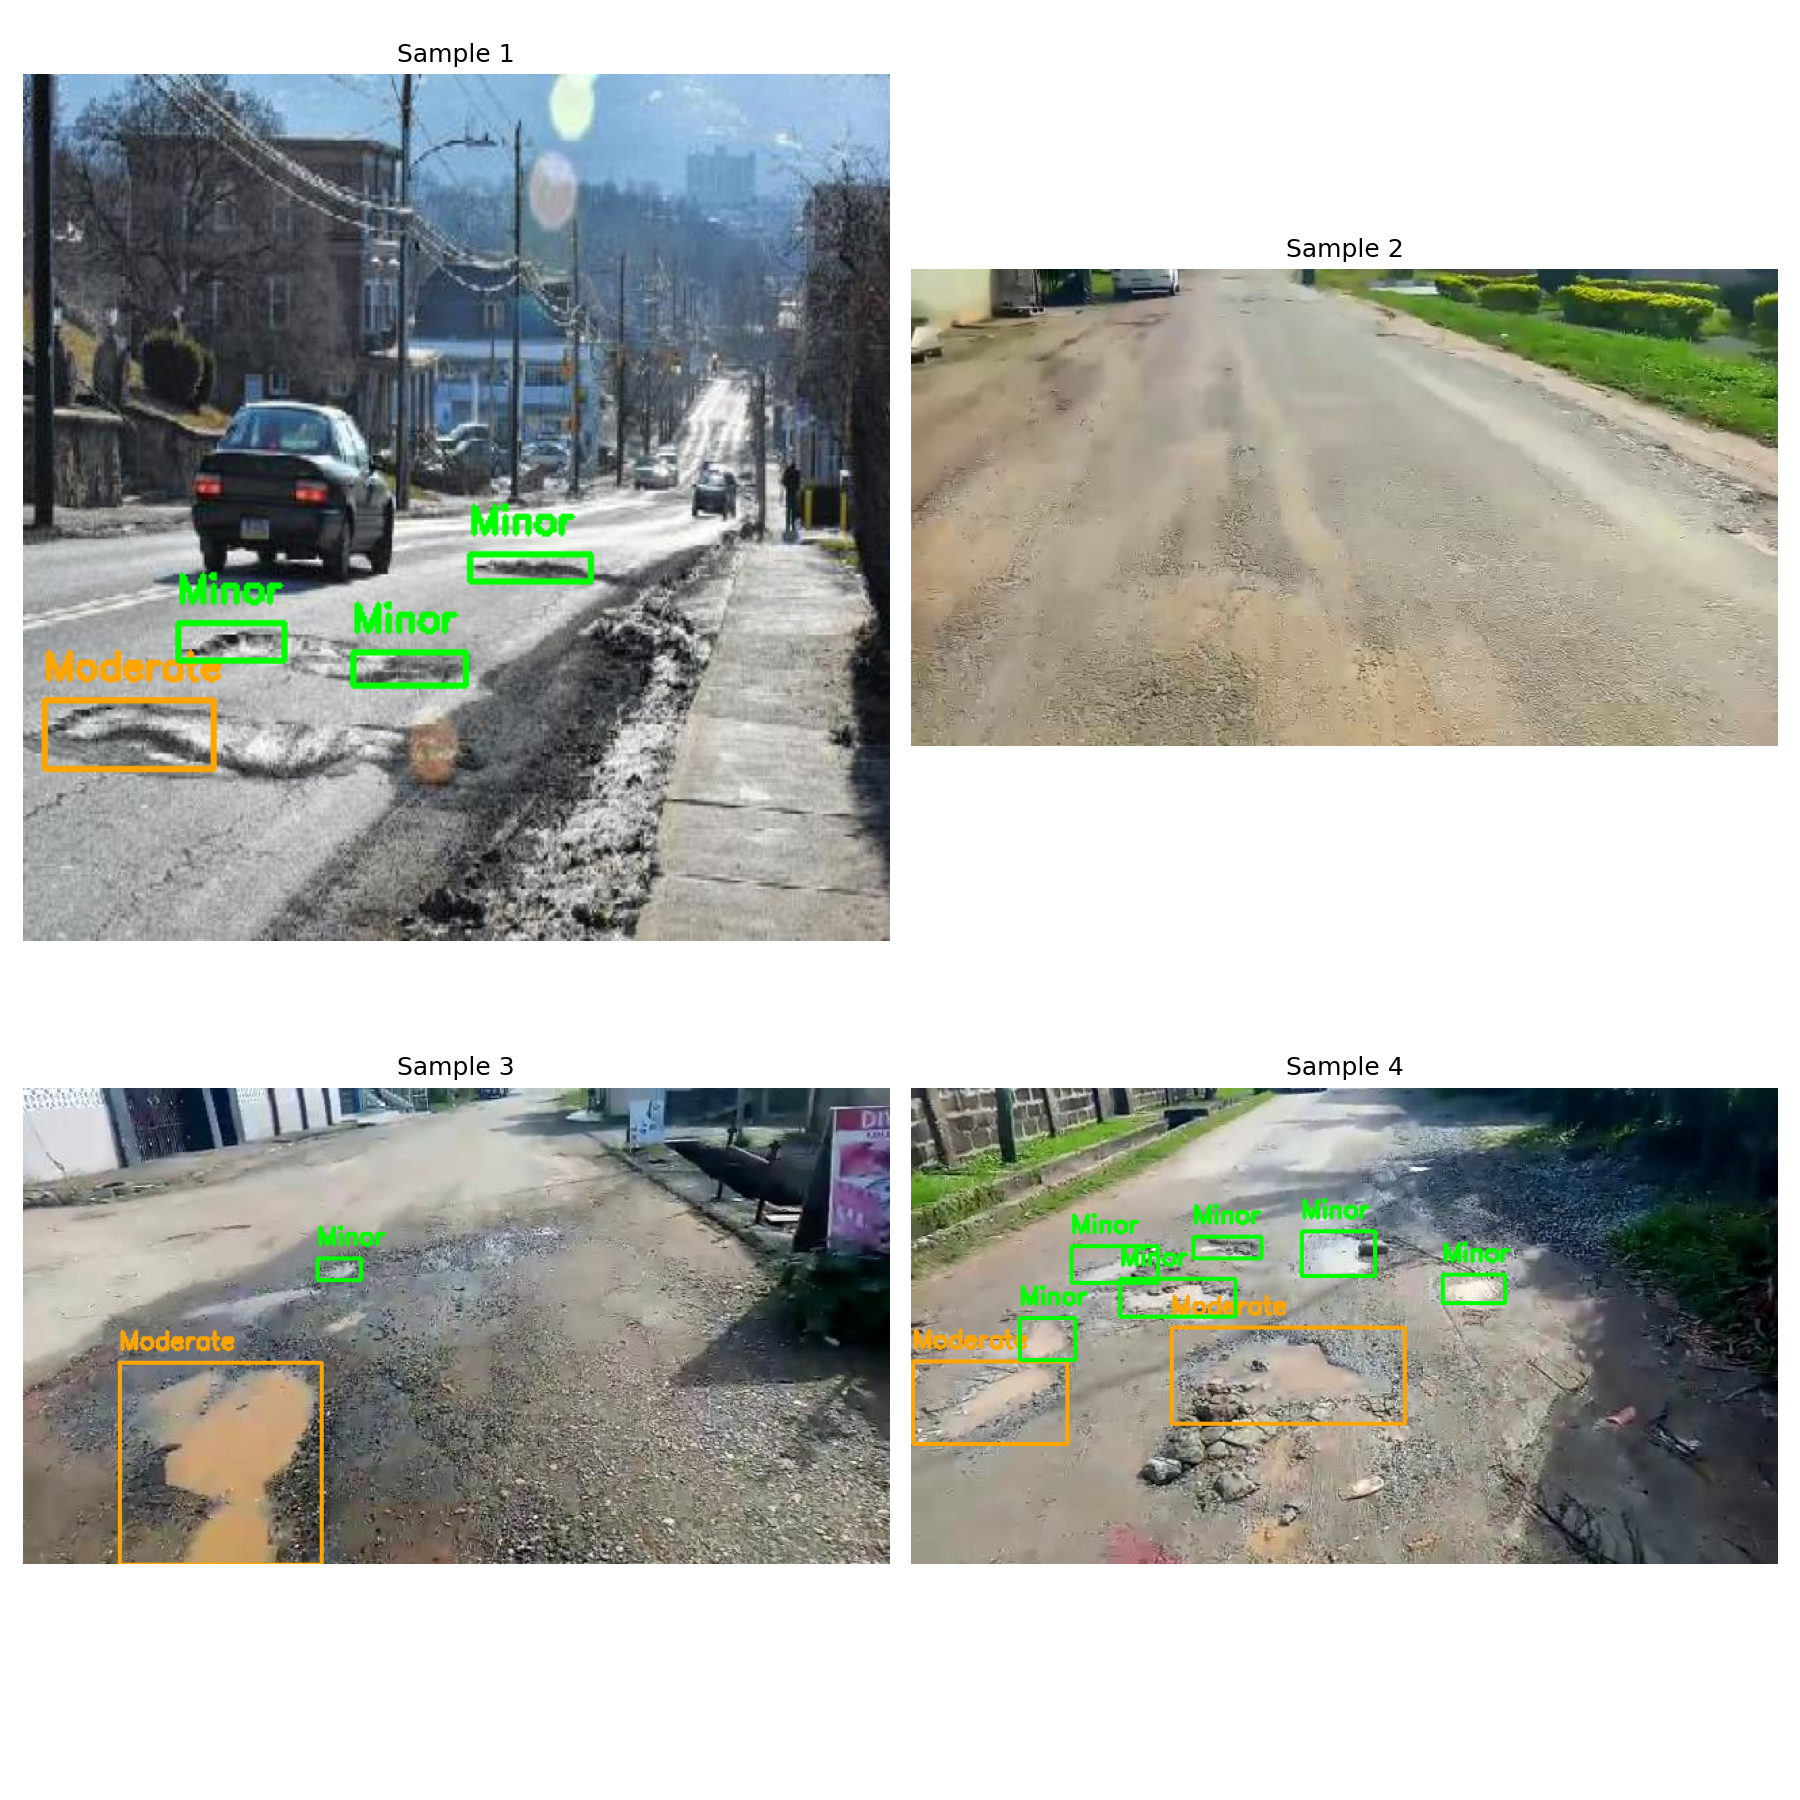


Inference Results:
✓ Green boxes = Minor severity potholes
✓ Orange boxes = Moderate severity potholes
✓ Red boxes = Severe severity potholes


In [16]:
# Display the saved inference examples
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display

inference_name = 'inference_examples.png'
inference_path = f'runs/detect/{detection_model_name}/{inference_name}'

# Display using IPython Image (better for notebooks)
display(IPImage(filename=inference_path))

print("\nInference Results:")
print("✓ Green boxes = Minor severity potholes")
print("✓ Orange boxes = Moderate severity potholes") 
print("✓ Red boxes = Severe severity potholes")